In [50]:
import argparse
import os
import re
import matplotlib.pyplot as plt
from datetime import datetime as dt
from image import load_image
from camera_model import CameraModel
import numpy as np
import cv2 as cv
from keras.models import model_from_json

Using TensorFlow backend.


In [80]:
models_dir = "/home/user/git/robotcar-dataset-sdk/extrinsics"
img_dir = "/home/user/Downloads/sample_small/stereo/centre"

cam_model = CameraModel(models_dir, img_dir)


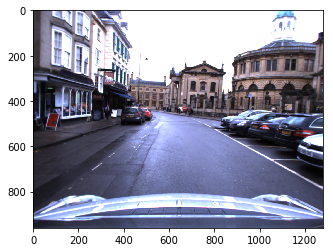

In [48]:
filename = os.path.join(img_dir, "1418381798139171.png")
img = load_image(filename, model)
img = np.round(img).astype(int)
cv.imwrite("test_img.png", img)
plt.imshow(img)
plt.show()

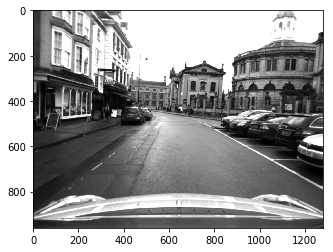

In [54]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

gray_img = rgb2gray(img)
plt.imshow(gray_img, cmap='gray')
plt.show()

# NeuralNet Stuff

In [51]:
# Get BINS_EDGE
BINS_EDGE = np.load("./nn_data/s1p10_bins_edge.npy")

# Get model prediction (kind of cheating to accelerate model demotration)
NUM_LABELS = 5
NUM_CLASSES = len(BINS_EDGE) - 1

In [53]:
MODEL_DIR = "./nn_data/"
MODEL_NAME = "bottom_half_s1p10_model_2019_06_04_20_34"

with open(MODEL_DIR + "%s.json" % MODEL_NAME, 'r') as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)

model.load_weights(MODEL_DIR + "%s.h5" % MODEL_NAME)
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [55]:
X = np.zeros((1, 200, 200, 1))
# get bottom half
bottom_half = gray_img[int(0.5 * gray_img.shape[0]) :, :]

# down sample & reshape image
_img = np.float32(cv.resize(bottom_half, (200, 200), interpolation=cv.INTER_AREA))
if len(_img.shape) == 2:
    _img = _img.reshape((200, 200, 1))

# store image to X
X[0, :, :, :] = _img

In [57]:
y_hat_list = model.predict(X)

In [61]:
def one_hot_to_angle(one_hot_arr):
    """
    Decode one hot encoded vector to get angle
    
    Input:
        one_hot_arr (np.ndarray): shape (1, num_classes)
        bins_edge (np.ndarray): shape (1, num_classes + 1)
    """
    angle_id = np.argmax(one_hot_arr)
    if angle_id < NUM_CLASSES:
        return (BINS_EDGE[angle_id] + BINS_EDGE[angle_id + 1]) / 2.
    else:
        return BINS_EDGE[angle_id]
    

def steering_angle_to_next_pos(angle, arc_length=2.0):
    """
    Calculate next position in the body frame of the current image frame
        Input:
            angle (float): steering angle in radian
    """
    if np.absolute(angle) < 1e-5:
        next_y = 0
        next_x = arc_length
    else:
        R = arc_length / angle
        next_y = R * (1 - np.cos(angle))
        next_x = R * np.sin(angle)
    return np.array([next_x, next_y])


def steering_angle_to_way_pts(y_hat):
    """
    Convert an array of steering angles to an array of way points
    
    Input
        y_hat (list): each element is np.ndarray shape (1, NUM_LABELS)
        
    Output
        np.ndarray, shape(6, 2) (1st column is x, 2nd column is y)
    """

    # Decode pred_y to get a sequence of steering angle
    pred_sequence = [one_hot_to_angle(y_hat[i]) for i in range(NUM_LABELS)]

    # initialize waypts
    way_pts = np.zeros((6, 2))
    for i, angle in enumerate(pred_sequence):
        next_pos = steering_angle_to_next_pos(angle)
        way_pts[i + 1, :] = way_pts[i, :] + next_pos 
        
    return pred_sequence, way_pts

In [67]:
y_hat = [y_hat_list[j][0, :] for j in range(NUM_LABELS)]
pred_sequence, way_pts = steering_angle_to_way_pts(y_hat)

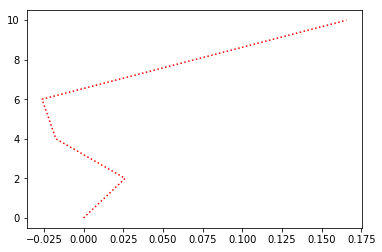

In [68]:
plt.plot(way_pts[:, 1], way_pts[:, 0], 'r:')
plt.show()

In [70]:
way_pts = way_pts + np.array([4., 0.12])

array([[  4.        ,   0.12      ],
       [  5.99977155,   0.14617838],
       [  7.99913698,   0.102552  ],
       [  9.9991116 ,   0.09382534],
       [ 11.99604146,   0.1897447 ],
       [ 13.99297132,   0.28566405]])

In [78]:
way_pts_3d = np.vstack((way_pts.T, np.zeros((1, 6)) + 1.52))
way_pts_3d

array([[  4.        ,   5.99977155,   7.99913698,   9.9991116 ,
         11.99604146,  13.99297132],
       [  0.12      ,   0.14617838,   0.102552  ,   0.09382534,
          0.1897447 ,   0.28566405],
       [  1.52      ,   1.52      ,   1.52      ,   1.52      ,
          1.52      ,   1.52      ]])

In [81]:
uv, _ = cam_model.project(way_pts_3d, img.shape)
uv
uv = np.round(uv).astype(int)
uv

array([[673, 667, 656, 653, 659, 663],
       [851, 729, 668, 631, 607, 589]])

In [82]:
for i in range(3):
    p1 = (uv[0, i], uv[1, i]) 
    p2 = (uv[0, i + 1], uv[1, i + 1])
    cv.line(gray_img, p1, p2, (0, 255, 0), 10)

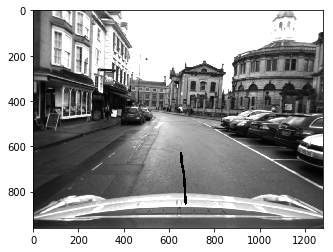

In [83]:
plt.imshow(gray_img, cmap='gray')
plt.show()